### **Differential Scorecards**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# datasets
from sklearn.datasets import load_iris
from ucimlrepo import fetch_ucirepo 
from io import StringIO

# discretization
from libraries.caimcaim import CAIMD # https://github.com/airysen/caimcaim/blob/master/caimcaim/caimcaim.py

# cv
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# grid search
from sklearn.model_selection import GridSearchCV

# objective function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from libsvm.svmutil import *

# regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import torch

##### datasets

**iris**:

In [3]:
iris_data = load_iris()
iris_X = pd.DataFrame(iris_data.data)
iris_y = pd.DataFrame(iris_data.target)

print("num observations: ", iris_y.count())
print("target distribution: ", iris_y.value_counts())

num observations:  0    150
dtype: int64
target distribution:  0
0    50
1    50
2    50
Name: count, dtype: int64


**adult**: predict whether annual income of an individual exceeds $50K/yr based on census data. 

In [4]:
# fetch dataset 
adult_data = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
adult_X = adult_data.data.features 
adult_y = adult_data.data.targets
adult_y.loc[:,'income'] = adult_y['income'].map({'>50K': 1, '<=50K': 0})
  
# metadata 
# print(adult_data.metadata) 
  
# variable information 
# print(adult_data.variables) 

print("num observations: ", adult_y.count())
print("target distribution: ", adult_y.value_counts())

num observations:  income    32561
dtype: int64
target distribution:  income
0.0       24720
1.0        7841
Name: count, dtype: int64


**mammo**: discrimination of benign and malignant mammographic masses based on BI-RADS attributes and the patient's age.

In [5]:
# fetch dataset 
mammo_data = fetch_ucirepo(id=161) 
  
# data (as pandas dataframes) 
mammo_X = mammo_data.data.features 
mammo_y = mammo_data.data.targets 

# drop rows with nulls
mammo_combined = pd.concat([mammo_X, mammo_y], axis=1)
print("num rows with nulls: ", mammo_combined.isnull().sum().sum())
mammo_combined = mammo_combined.dropna()
mammo_combined = mammo_combined.reset_index(drop=True)
mammo_X = mammo_combined.iloc[:, :-1]
mammo_y = mammo_combined.iloc[:, -1]


# metadata 
# print(mammo_data.metadata) 
  
# variable information 
# print(mammo_data.variables) 

print("num observations: ", mammo_y.count())
print("target distribution: ", mammo_y.value_counts())

num rows with nulls:  162
num observations:  830
target distribution:  Severity
0    427
1    403
Name: count, dtype: int64


**mushroom**: mushrooms described in terms of physical characteristics; classification: poisonous or edible

In [6]:
# fetch dataset 
mushroom_data = fetch_ucirepo(id=73) 

# data (as pandas dataframes) 
mushroom_X = mushroom_data.data.features 
mushroom_y = mushroom_data.data.targets 
mushroom_y.loc[:, 'poisonous'] = mushroom_y['poisonous'].map({'p': 1, 'e': 0})
  
# metadata 
# print(mushroom_data.metadata) 
  
# variable information 
# print(mushroom_data.variables) 

print("num observations: ", mushroom_y.count())
print("target distribution: ", mushroom_y.value_counts())

num observations:  poisonous    8124
dtype: int64
target distribution:  poisonous
0            4208
1            3916
Name: count, dtype: int64


**spambase**: classifying Email as Spam or Non-Spam

In [7]:
# fetch dataset 
spambase_data = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
spambase_X = spambase_data.data.features 
spambase_y = spambase_data.data.targets 
  
# metadata 
# print(spambase_data.metadata) 
  
# variable information 
# print(spambase_data.variables) 

print("num observations: ", spambase_y.count())
print("target distribution: ", spambase_y.value_counts())

num observations:  Class    4601
dtype: int64
target distribution:  Class
0        2788
1        1813
Name: count, dtype: int64


**telemarketing**: set of possible advertisements on Internet pages

In [8]:
# load dataset from file. target is last column
telemarketing_data = pd.read_csv('datasets/internet+advertisements/ad.data', dtype=str)
telemarketing_X = telemarketing_data.iloc[:, :-1]
telemarketing_y = telemarketing_data.iloc[:, -1]

telemarketing_y = telemarketing_y.map({'nonad.': 0, 'ad.': 1})

print("num observations: ", telemarketing_y.count())
print("target distribution: ", telemarketing_y.value_counts())

num observations:  3278
target distribution:  ad.
0    2820
1     458
Name: count, dtype: int64


**sleep apnea**:

In [9]:
sleep_apnea_data = pd.read_csv('datasets/bdsp_psg_master_20231101.csv')

**appendicitis**: https://sci2s.ugr.es/keel/dataset.php?cod=183#sub2

In [10]:
with open('datasets/appendicitis.dat', "r") as file:
    lines = file.readlines()

data_start_ind = lines.index("@data\n") + 1
app_data = lines[data_start_ind:]
app_data = pd.read_csv(StringIO("".join(app_data)), header=None)

app_data.columns = ["At1", "At2", "At3", "At4", "At5", "At6", "At7", "Class"]

app_X = app_data.iloc[:, :-1]
app_y = app_data.iloc[:, -1]

print("num observations: ", app_y.count())
print("target distribution: ", app_y.value_counts())

num observations:  106
target distribution:  Class
0    85
1    21
Name: count, dtype: int64


aesthetic evaluation

In [11]:
aesthetic_evaluation_data = pd.read_csv('datasets/aesthetic_evaluation_data.csv')
aesthetic_evaluation_data = aesthetic_evaluation_data.drop(columns=['Image Filename','Author','Objective Evaluation'])
aesthetic_evaluation_X = aesthetic_evaluation_data.drop(columns='Subjective Evaluation')
aesthetic_evaluation_y = aesthetic_evaluation_data['Subjective Evaluation']

aesthetic_evaluation_data.head()

,Subjective Evaluation,BRA Value,LBC Value,UNR Value,BCE Value,BCD Value,BAD Value,BOD Value,pBRA Value,pLBC Value,...,cEMDb Value,cEMDLab Value,sX2L Value,sX2a Value,sX2b Value,sX2Lab Value,sEMDL Value,sEMDa Value,sEMDb Value,sEMDLab Value
0,Good,1.149009,0.830915,0.107618,0.938534,1.934477,4.885198,17.296370,0.049401,0.033356,...,0.291363,0.210082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Good,2.368824,1.326447,1.599444,0.272997,0.035378,19.932998,68.761479,0.113919,0.058509,...,0.351693,0.105346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Good,1.409939,0.950935,0.278358,1.229293,2.221074,22.277770,38.323430,0.067231,0.038613,...,0.304185,0.049345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Good,2.059918,0.720926,1.786307,1.065381,1.995007,25.163410,31.631070,0.100705,0.032141,...,0.137693,0.031455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Good,2.452595,0.798596,1.868745,1.070148,1.218189,0.395585,31.426783,0.117249,0.035235,...,0.091768,0.030546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
a = aesthetic_evaluation_data[['sX2L Value','sX2a Value','sX2b Value','sX2Lab Value','sEMDL Value','sEMDa Value','sEMDb Value','sEMDLab Value']]
a.sum()

sX2L Value       0.0
sX2a Value       0.0
sX2b Value       0.0
sX2Lab Value     0.0
sEMDL Value      0.0
sEMDa Value      0.0
sEMDb Value      0.0
sEMDLab Value    0.0
dtype: float64

In [13]:
aesthetic_evaluation_y.value_counts()

Subjective Evaluation
Good         595
Fair         353
Excellent    308
Poor         102
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Subjective Evaluation')

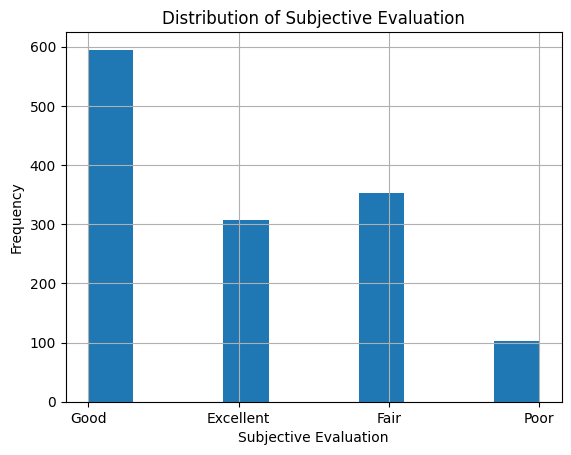

In [14]:
aesthetic_evaluation_y.hist()
plt.xlabel('Subjective Evaluation')
plt.ylabel('Frequency')
plt.title('Distribution of Subjective Evaluation')

In [15]:
# create binary target from aesthetic evaluation, by joining good and excellent, and fair and poor
aesthetic_evaluation_binary_y = aesthetic_evaluation_y.map({'Excellent': 1, 'Good': 1, 'Fair': 0, 'Poor': 0})

# distribution
aesthetic_evaluation_binary_y.value_counts()

Subjective Evaluation
1    903
0    455
Name: count, dtype: int64

#### discretization thresholds

CAIM

In [16]:
# discretize using CAIM
def discretize_caim_df(data, X, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    
    print("\nCut-off points: ", caim.split_scheme)
    print("Number of bins: ", end="")
    for i, (key, value) in enumerate(caim.split_scheme.items()):
        if i == len(caim.split_scheme) - 1:
            print(f" {key}: {len(value)+1}", end="")
        else:
            print(f" {key}: {len(value)+1}", end=",")
    print()
    
    X_disc_caim = pd.DataFrame(X_disc_caim, columns=X.columns).astype(int) # convert to pandas dataframe and int
        
    return X_disc_caim

''' 
prints of fit() method: Categorical list_of_(indicies)_categorical_features
    # feature_index  GLOBAL CAIM  best_caim_value 
in the returning dataframe:\
    - columns represent the original features
    - rows represent each instance
    - values are the bin number each instance belongs to (starting from 0)
'''

def discretize_caim(X, cols, y):
    caim = CAIMD()
    X_disc_caim = caim.fit_transform(X, y) # fit() and transform()
    # get thresholds from caim.split_scheme (dict with column index : thresholds)
    # transform all values to floats
    # and keys with column indexes to column names
    thresholds = {cols[i]: [float(val) for val in value] for i, (key, value) in enumerate(caim.split_scheme.items())}
    return thresholds


In [17]:
app_thresholds_caim = discretize_caim(app_X, app_X.columns, app_y)
print("\nthresholds ", app_thresholds_caim)

print("num of bins: ")
for i, (key, value) in enumerate(app_thresholds_caim.items()):
        print(f"  {key}: {len(value)+1}")

Categorical []
# 0  GLOBAL CAIM  41.18488372093023
# 1  GLOBAL CAIM  39.99669148056245
# 2  GLOBAL CAIM  41.745054945054946
# 3  GLOBAL CAIM  35.090659340659336
# 4  GLOBAL CAIM  37.25892316999395
# 5  GLOBAL CAIM  38.4981684981685
# 6  GLOBAL CAIM  41.83013879709187

thresholds  {'At1': [0.0, 0.213, 2.0], 'At2': [0.0, 0.411, 2.0], 'At3': [0.0, 0.153, 2.0], 'At4': [0.0, 0.056, 2.0], 'At5': [0.0, 0.029, 2.0], 'At6': [0.0, 0.421, 2.0], 'At7': [0.0, 0.145, 2.0]}
num of bins: 
  At1: 4
  At2: 4
  At3: 4
  At4: 4
  At5: 4
  At6: 4
  At7: 4


infinitesimal bins

In [18]:
# discretize using infinitesimal bins:
# thresholds are the points in between 2 consecutive values in the sorted list

def discretize_infbins(X, cols):
    infbins_thresholds = {}
    for col in cols:
        # sort unique values
        sorted_col = np.unique(X[col])
        # get thresholds
        thresholds = (sorted_col[:-1] + sorted_col[1:]) / 2
        infbins_thresholds[col] = thresholds.tolist()

    return infbins_thresholds

In [19]:
app_thresholds_infbins = discretize_infbins(app_X, app_X.columns)
print("thresholds ", app_thresholds_infbins)
print("num of bins: ")
for i, (key, value) in enumerate(app_thresholds_infbins.items()):
        print(f"  {key}: {len(value)+1}")

thresholds  {'At1': [0.0135, 0.0425, 0.06, 0.0665, 0.07999999999999999, 0.0935, 0.1, 0.109, 0.118, 0.131, 0.16449999999999998, 0.189, 0.1955, 0.202, 0.2085, 0.2155, 0.22, 0.2265, 0.23349999999999999, 0.2535, 0.27749999999999997, 0.291, 0.3, 0.311, 0.3245, 0.33999999999999997, 0.3555, 0.362, 0.3665, 0.371, 0.3755, 0.3845, 0.3935, 0.398, 0.40449999999999997, 0.411, 0.4155, 0.42, 0.4245, 0.429, 0.4355, 0.4445, 0.451, 0.4555, 0.46, 0.4645, 0.469, 0.4755, 0.4845, 0.491, 0.4975, 0.5045, 0.509, 0.5135000000000001, 0.518, 0.522, 0.531, 0.547, 0.5645, 0.58, 0.589, 0.602, 0.6174999999999999, 0.6245, 0.6445000000000001, 0.671, 0.682, 0.7175, 0.7575000000000001, 0.771, 0.787, 0.8400000000000001, 0.942], 'At2': [0.0805, 0.16999999999999998, 0.1875, 0.20500000000000002, 0.223, 0.241, 0.259, 0.2945, 0.33899999999999997, 0.366, 0.393, 0.42, 0.4465, 0.473, 0.491, 0.509, 0.536, 0.5625, 0.58, 0.598, 0.616, 0.634, 0.652, 0.67, 0.6965, 0.723, 0.741, 0.759, 0.777, 0.795, 0.8125, 0.83, 0.848, 0.866, 0.884, 0

#### discretized version

num of columns in the new df = (num thresholds + 1) * num features = num bins * num features

2 methods
- 1 out of k: 1 if the value is in the bin, 0 otherwise
- differential coding: 1 from bin 1 until bin where the value is in, 0 otherwise

In [20]:
def get_bins(thresholds, values):
    bins = np.digitize(values, thresholds)
    return bins
    # list of bin number for each row


def disc_1_out_of_k(X, cols, thresholds):
    disc_df = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        bins_df = pd.get_dummies(bins, prefix=f'feat{col}-bin', prefix_sep='').astype(int) # one hot encoding
        #for i in range(1, len(thresholds[col]) + 1):
        #    if f'feat{col}-bin_{i}' not in bins_df.columns:
        #        bins_df[f'feat{col}-bin{i}'] = 0
        bins_df = bins_df.drop(columns=f'feat{col}-bin0', errors='ignore')
        disc_df.append(bins_df)    
    return pd.concat(disc_df, axis=1)


def disc_diff_coding(X, cols, thresholds):
    bin_dfs = []
    for col in cols:
        bins = get_bins(thresholds[col], X[col]) # gets bin number of each row
        num_bins = len(thresholds[col]) + 1
        bin_df = pd.DataFrame(0, index=X.index, columns=[f'feat{col}-bin{i}' for i in range(1, num_bins)])
        for i in range(1, num_bins):
            bin_df[f'feat{col}-bin{i}'] = (bins >= i).astype(int)
        bin_dfs.append(bin_df)
    return pd.concat(bin_dfs, axis=1)


In [21]:
app_X_disc_caim_1outofk = disc_1_out_of_k(app_X, app_X.columns, app_thresholds_caim)
disc_app_X = app_X_disc_caim_1outofk
app_X_disc_caim_1outofk.head()

,featAt1-bin1,featAt1-bin2,featAt2-bin1,featAt2-bin2,featAt3-bin1,featAt3-bin2,featAt4-bin1,featAt4-bin2,featAt5-bin1,featAt5-bin2,featAt6-bin1,featAt6-bin2,featAt7-bin1,featAt7-bin2
0,0,1,0,1,0,1,1,0,1,0,0,1,0,1
1,0,1,0,1,0,1,0,1,0,1,0,1,0,1
2,1,0,0,1,1,0,0,1,1,0,0,1,1,0
3,1,0,1,0,1,0,0,1,0,1,1,0,1,0
4,0,1,0,1,0,1,0,1,0,1,0,1,0,1


In [22]:
app_X_disc_caim_diffcod = disc_diff_coding(app_X, app_X.columns, app_thresholds_caim)
app_X_disc_caim_diffcod.head()

,featAt1-bin1,featAt1-bin2,featAt1-bin3,featAt2-bin1,featAt2-bin2,featAt2-bin3,featAt3-bin1,featAt3-bin2,featAt3-bin3,featAt4-bin1,...,featAt4-bin3,featAt5-bin1,featAt5-bin2,featAt5-bin3,featAt6-bin1,featAt6-bin2,featAt6-bin3,featAt7-bin1,featAt7-bin2,featAt7-bin3
0,1,1,0,1,1,0,1,1,0,1,...,0,1,0,0,1,1,0,1,1,0
1,1,1,0,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,1,1,0
2,1,0,0,1,1,0,1,0,0,1,...,0,1,0,0,1,1,0,1,0,0
3,1,0,0,1,0,0,1,0,0,1,...,0,1,1,0,1,0,0,1,0,0
4,1,1,0,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,1,1,0


In [23]:
app_X_disc_infbins_1outofk = disc_1_out_of_k(app_X, app_X.columns, app_thresholds_infbins)
app_X_disc_infbins_1outofk.head()

,featAt1-bin1,featAt1-bin2,featAt1-bin3,featAt1-bin4,featAt1-bin5,featAt1-bin6,featAt1-bin7,featAt1-bin8,featAt1-bin9,featAt1-bin10,...,featAt7-bin89,featAt7-bin90,featAt7-bin91,featAt7-bin92,featAt7-bin93,featAt7-bin94,featAt7-bin95,featAt7-bin96,featAt7-bin97,featAt7-bin98
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
app_X_disc_infbins_diffcod = disc_diff_coding(app_X, app_X.columns, app_thresholds_infbins)
app_X_disc_infbins_diffcod.head()

,featAt1-bin1,featAt1-bin2,featAt1-bin3,featAt1-bin4,featAt1-bin5,featAt1-bin6,featAt1-bin7,featAt1-bin8,featAt1-bin9,featAt1-bin10,...,featAt7-bin89,featAt7-bin90,featAt7-bin91,featAt7-bin92,featAt7-bin93,featAt7-bin94,featAt7-bin95,featAt7-bin96,featAt7-bin97,featAt7-bin98
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


#### 10 fold CV

In [25]:
def cross_val_score(model, X, y, n_splits=10):
    kf = KFold(n_splits=n_splits)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(mean_squared_error(y_test, y_pred))
    return np.mean(scores)

#### regularization

In [26]:
alpha = [0.01, 0.1, 0.4, 0.6, 0.9, 0.99]
ridge = Ridge()
lasso = Lasso()
elastic_net = ElasticNet()

param_grid = {'alpha': alpha}

def grid_search(model, X, y, param_grid, cv=10):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    grid_search.fit(X, y)
    return grid_search

#### objective function

In [27]:
def get_weights(model, disc_X, y):
    model.fit(disc_X, y)
    weights = model.coef_[0]
    feature_names = disc_X.columns
    weights_df = pd.DataFrame({'Feature': feature_names, 'Weight': weights})
    return weights_df

RSS weights:
          Feature    Weight
0   featAt1-bin1  0.333609
1   featAt1-bin2  0.333609
2   featAt2-bin1  0.333609
3   featAt2-bin2  0.333609
4   featAt3-bin1  0.333609
5   featAt3-bin2  0.333609
6   featAt4-bin1  0.333609
7   featAt4-bin2  0.333609
8   featAt5-bin1  0.333609
9   featAt5-bin2  0.333609
10  featAt6-bin1  0.333609
11  featAt6-bin2  0.333609
12  featAt7-bin1  0.333609
13  featAt7-bin2  0.333609


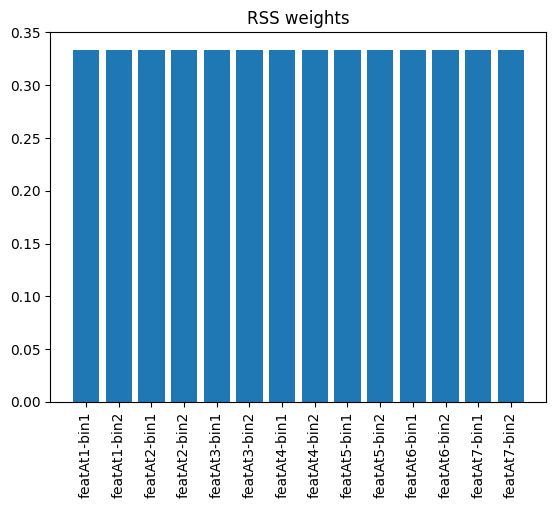

In [28]:
# RSS
def rss(X, y):
    # linear_regression = LinearRegression()
    linear_regression = Lasso()
    param_grid = {'alpha': alpha}
    grid_search_rss = grid_search(linear_regression, X, y, param_grid)
    best_model_rss = grid_search_rss.best_estimator_
    weights_rss = get_weights(best_model_rss, X, y)
    print("RSS weights:\n", weights_rss)

    # plot
    plt.figure()
    plt.bar(weights_rss['Feature'], weights_rss['Weight'])
    plt.xticks(rotation=90)
    plt.title('RSS weights')
    plt.show()

    return weights_rss

app_weights_rss = rss(disc_app_X, app_y)

ML weights:
          Feature    Weight
0   featAt1-bin1  1.219833
1   featAt1-bin2 -0.587676
2   featAt2-bin1  0.178000
3   featAt2-bin2 -0.387128
4   featAt3-bin1  0.000000
5   featAt3-bin2  0.000000
6   featAt4-bin1  0.496520
7   featAt4-bin2 -0.574368
8   featAt5-bin1  0.000000
9   featAt5-bin2  0.000000
10  featAt6-bin1  0.148922
11  featAt6-bin2 -0.260905
12  featAt7-bin1  0.025322
13  featAt7-bin2 -0.619301


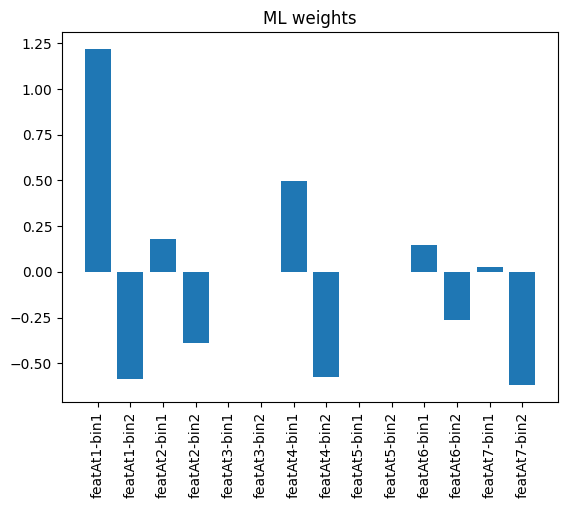

In [29]:
# maximum likelihood (GLM with binomial response and logit link function)
def max_likelihood(X, y):
    logistic = LogisticRegression()
    logistic.solver = 'liblinear'
    logistic.penalty = 'l1'
    weights_ml = get_weights(logistic, X, y)
    print("ML weights:\n", weights_ml)

    # plot
    plt.figure()
    plt.bar(weights_ml['Feature'], weights_ml['Weight'])
    plt.xticks(rotation=90)
    plt.title('ML weights')
    plt.show()

    return weights_ml

app_weights_ml = max_likelihood(disc_app_X, app_y)

SVM weights:
          Feature        Weight
0   featAt1-bin1  2.343750e-01
1   featAt1-bin2 -2.343750e-01
2   featAt2-bin1  1.718750e-01
3   featAt2-bin2 -1.718750e-01
4   featAt3-bin1  2.343750e-01
5   featAt3-bin2 -2.343750e-01
6   featAt4-bin1 -1.387779e-17
7   featAt4-bin2  0.000000e+00
8   featAt5-bin1  1.562500e-02
9   featAt5-bin2 -1.562500e-02
10  featAt6-bin1  1.093750e-01
11  featAt6-bin2 -1.093750e-01
12  featAt7-bin1  2.343750e-01
13  featAt7-bin2 -2.343750e-01


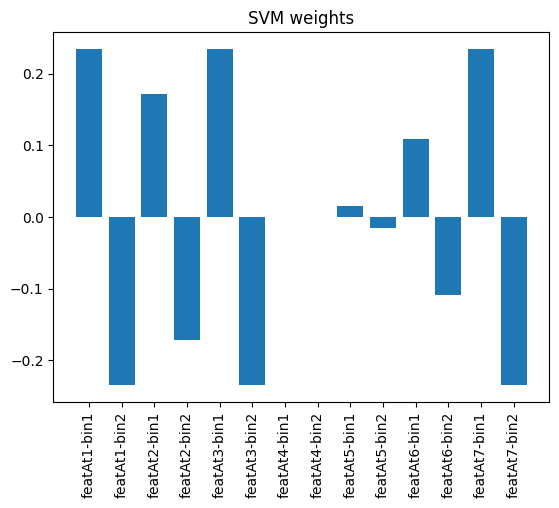

In [30]:
# margin maximization (linear SVM)
def margin_max(X, y):
    param_grid = {
        'C': [2**i for i in range(-10, 11)]
    }
    svm = SVC(kernel='linear')
    #svm = svm_problem(app_y, disc_app_X)
    grid_search_svm = grid_search(svm, X, y, param_grid)
    best_model_svm = grid_search_svm.best_estimator_
    weights_svm = get_weights(best_model_svm, X, y)
    print("SVM weights:\n", weights_svm)

    # plot
    plt.figure()
    plt.bar(weights_svm['Feature'], weights_svm['Weight'])
    plt.xticks(rotation=90)
    plt.title('SVM weights')
    plt.show()

    return weights_svm

app_weights_svm = margin_max(disc_app_X, app_y)

ML weights:
            Feature  Weight
0     featAt1-bin1     0.0
1     featAt1-bin2     0.0
2     featAt1-bin3     0.0
3     featAt1-bin4     0.0
4     featAt1-bin5     0.0
..             ...     ...
518  featAt7-bin94     0.0
519  featAt7-bin95     0.0
520  featAt7-bin96     0.0
521  featAt7-bin97     0.0
522  featAt7-bin98     0.0

[523 rows x 2 columns]


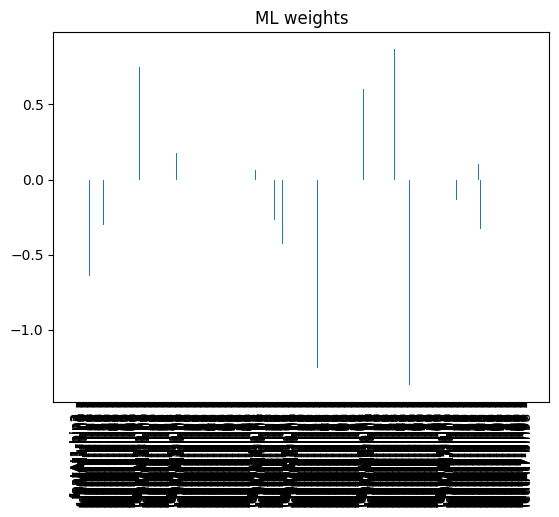

           Feature    Weight
15   featAt1-bin16 -0.641044
31   featAt1-bin32 -0.777615
32   featAt1-bin33 -0.303129
73    featAt2-bin1  0.745676
103  featAt2-bin31 -0.884366
116   featAt3-bin4  0.174827
126  featAt3-bin14 -0.307836
133  featAt3-bin21 -1.059011
208   featAt4-bin2  0.063877
230  featAt4-bin24 -0.268655
239  featAt4-bin33 -0.431716
280  featAt5-bin36 -1.254900
333   featAt6-bin1  0.604960
369  featAt6-bin37  0.867580
386  featAt6-bin54 -1.367111
439  featAt7-bin15 -0.334286
441  featAt7-bin17 -0.137691
466  featAt7-bin42  0.104603
469  featAt7-bin45 -0.327740


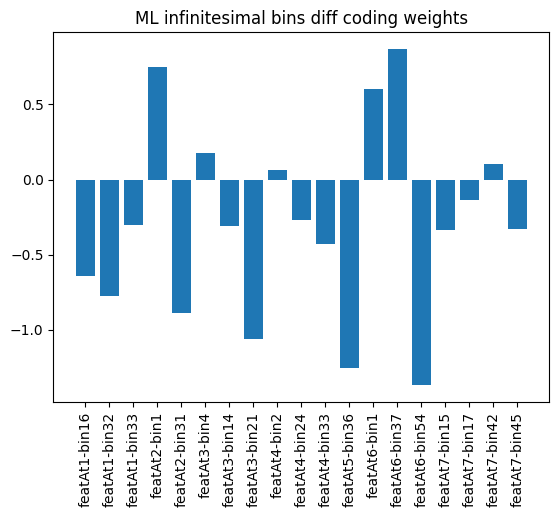

In [31]:
disc_app_X = app_X_disc_infbins_diffcod
app_weights_ml = max_likelihood(disc_app_X, app_y)

# get the weights that are not 0
app_weights = app_weights_ml[app_weights_ml['Weight'] != 0]
print(app_weights)
plt.figure()
plt.bar(app_weights['Feature'], app_weights['Weight'])
plt.xticks(rotation=90)
plt.title('ML infinitesimal bins diff coding weights')
plt.show()

SVM weights:
            Feature    Weight
0     featAt1-bin1 -0.003196
1     featAt1-bin2  0.000710
2     featAt1-bin3 -0.003196
3     featAt1-bin4  0.000710
4     featAt1-bin5 -0.000992
..             ...       ...
518  featAt7-bin94  0.003906
519  featAt7-bin95  0.003906
520  featAt7-bin96  0.003906
521  featAt7-bin97  0.003906
522  featAt7-bin98  0.003906

[523 rows x 2 columns]


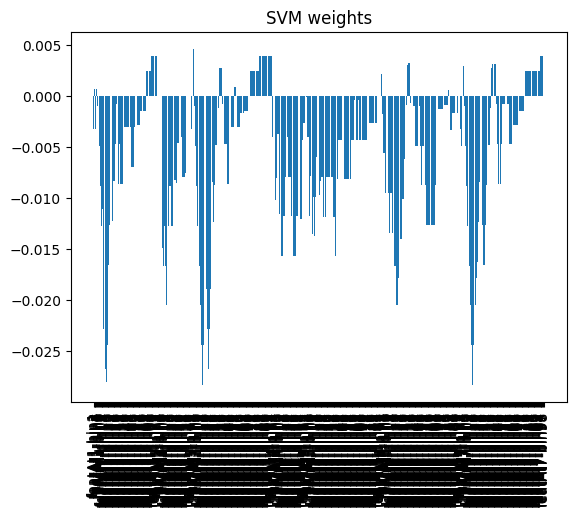

           Feature    Weight
0     featAt1-bin1 -0.003196
1     featAt1-bin2  0.000710
2     featAt1-bin3 -0.003196
3     featAt1-bin4  0.000710
4     featAt1-bin5 -0.000992
..             ...       ...
518  featAt7-bin94  0.003906
519  featAt7-bin95  0.003906
520  featAt7-bin96  0.003906
521  featAt7-bin97  0.003906
522  featAt7-bin98  0.003906

[510 rows x 2 columns]


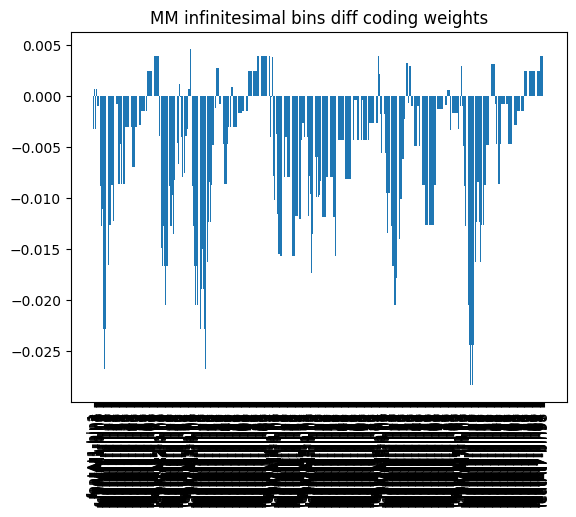

In [32]:
app_weights_mm = margin_max(disc_app_X, app_y)

# get the weights that are not 0
app_weights = app_weights_mm[app_weights_mm['Weight'] != 0]
print(app_weights)
plt.figure()
plt.bar(app_weights['Feature'], app_weights['Weight'])
plt.xticks(rotation=90)
plt.title('MM infinitesimal bins diff coding weights')
plt.show()

In [ ]:
# supersparse linear classifier
def supersparse_linear_classif(X, y):
    # weight
    n = X.shape[1] # dimension of X
    weights = torch.as_tensor([1]*n, dtype=torch.float64)
    # bias
    bias = torch.as_tensor(1, dtype=torch.float64)
    
    y = torch.as_tensor(y, dtype=torch.float64)
    X = torch.as_tensor(X.values, dtype=torch.float64)
    
    lr = 0.01
    num_iters = 100
    l1 = 0.2

    # gradient descent
    for i in range(num_iters):
        y_pred = torch.mv(X, weights) + bias
        # gradient of RSS (X^T(y - y_pred))
        grad = torch.mv(X.t(), y - y_pred) - l1 * torch.sign(weights)
        # update weights
        weights += lr * grad
        
        weights[torch.abs(weights) < 0.01] = 0
    return weights

app_weights_sslc = supersparse_linear_classif(disc_app_X, app_y)
print(app_weights_sslc)
print("num of non-zero weights: ", torch.sum(app_weights_sslc != 0))


tensor([2.7058e+231, 2.6921e+231, 2.6776e+231, 2.6577e+231, 2.6539e+231,
        2.6513e+231, 2.6403e+231, 2.6303e+231, 2.6212e+231, 2.6139e+231,
        2.5910e+231, 2.5707e+231, 2.5588e+231, 2.5371e+231, 2.5310e+231,
        2.4952e+231, 2.4736e+231, 2.4430e+231, 2.4298e+231, 2.3649e+231,
        2.3239e+231, 2.3013e+231, 2.2329e+231, 2.2163e+231, 2.1884e+231,
        2.1654e+231, 2.1471e+231, 2.1202e+231, 2.0692e+231, 2.0434e+231,
        1.9934e+231, 1.9193e+231, 1.8857e+231, 1.8349e+231, 1.8063e+231,
        1.7438e+231, 1.6652e+231, 1.6349e+231, 1.6000e+231, 1.5421e+231,
        1.5067e+231, 1.3880e+231, 1.3297e+231, 1.2625e+231, 1.2332e+231,
        1.1976e+231, 1.1692e+231, 1.0824e+231, 1.0509e+231, 1.0159e+231,
        9.8858e+230, 9.2248e+230, 8.8622e+230, 8.5331e+230, 7.9480e+230,
        7.2170e+230, 6.8864e+230, 6.5600e+230, 5.8684e+230, 5.4876e+230,
        5.1004e+230, 4.8363e+230, 4.1390e+230, 3.7707e+230, 3.0865e+230,
        2.7537e+230, 2.4440e+230, 2.1471e+230, 1.77

#### SBC (single binary classifier) reduction